In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from bbg import bdh, bdh_bulk, Pybbg
import matplotlib.pyplot as plt
import plotly
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import numpy as np
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.express as px
pd.options.plotting.backend = "matplotlib"
import pdblp
from datetime import timedelta

In [2]:
df = pd.read_excel('etf.xlsx')
del df['Unnamed: 0']
# update data
a = Pybbg()
field = a.bdp(ticker = df.Ticker,fld_list =  ['CURRENT_TRR_3YR','CURRENT_TRR_1YR' ,'CURRENT_TRR_YTD','FUND_PE_RATIO','EQY_SHARPE_RATIO_1YR','EQY_SHARPE_RATIO_5YR','CURRENT_ANN_TRR_5YR']).transpose()
field.index.name = 'Ticker'
field.reset_index(inplace = True)
df = df.merge(field, on ='Ticker')
# df.to_excel('etf_new.xlsx')
#chang pe ratio to negative for the ease of recommendation list
df['FUND_PE_RATIO']  = df['FUND_PE_RATIO'] * (-1)
df['industry'] = df.industry.fillna(value ='Thematic')

### Top recommendations

In [3]:
# scoring criteri
scoring_dic = {'EQY_SHARPE_RATIO_1YR':0.1,'EQY_SHARPE_RATIO_5YR':0.4,'CURRENT_ANN_TRR_5YR':0.1,'CURRENT_TRR_1YR':0.1,
           'CURRENT_TRR_YTD':0.2,'FUND_PE_RATIO':0.1}


def scoring(scoring_dic): 
    """scoring_dic = {'EQY_SHARPE_RATIO_1YR':0.2,'EQY_SHARPE_RATIO_5YR':0.2,'CURRENT_ANN_TRR_5YR':0.2,'CURRENT_TRR_1YR':0.2,
           'CURRENT_TRR_YTD':0.2} """
    rst = df[['Name','Ticker','style','industry'] + list(scoring_dic.keys())]
    for i in scoring_dic.keys(): 
        rst[i] = (rst[i].rank()) * scoring_dic [i]

    rst['total_score'] = rst[list(scoring_dic.keys())].sum(axis = 1)
    rst['total_score'] = (rst['total_score'] /rst['total_score'].max()) * 100 
    rst = rst.sort_values(by = 'total_score', ascending = False)
    return rst 

recommendation = scoring(scoring_dic)
df = df.merge(recommendation[['Ticker','total_score']]).sort_values(by = 'total_score',ascending = False)
df[['Name','Ticker','style','industry','total_score','holdings'] + list(scoring_dic.keys())].head(10)

Name          Ticker   style    industry  \
3           VANECK SEMICONDUCTOR   SMH US Equity  Growth  Technology   
17  INVESCO DYNAMIC SEMICONDUCTO   PSI US Equity  Growth  Technology   
24  FIRST TRUST NASDAQ CLEAN EDG  QCLN US Equity  Growth      Energy   
2             ARK INNOVATION ETF  ARKK US Equity  Growth    Thematic   
20   ARK AUTONOMOUS TECH & ROBOT  ARKQ US Equity  Growth    Thematic   
35  INVESCO WILDERHILL CLEAN ENE   PBW US Equity  Growth    Thematic   
62   ISHARES GLOBAL CLEAN ENERGY  ICLN US Equity  Growth      Energy   
54  GLOBAL X LITHIUM & BATTERY T   LIT US Equity   Blend   Materials   
56   INVESCO GLOBAL CLEAN ENERGY   PBD US Equity  Growth    Thematic   
16    SPDR S&P SEMICONDUCTOR ETF   XSD US Equity  Growth  Technology   

    total_score  holdings  EQY_SHARPE_RATIO_1YR  EQY_SHARPE_RATIO_5YR  \
3    100.000000      25.0                  1.67                  1.37   
17    99.270675      31.0                  1.48                  1.21   
24    99.232623      44.0                  2.41                  1.15   
2     98.858447      51.0                  2.44                  1.31   
20    97.983257      42.0                  2.35                  1.21   
35    97.685185      56.0                  2.26                  1.05   
62    97.387113      31.0                  2.40                  0.98   
54    97.298326      45.0                  2.28                  1.01   
56    97.146119     108.0                  2.36                  1.02   
16    97.082699      39.0                  1.67                  1.24   

    CURRENT_ANN_TRR_5YR  CURRENT_TRR_1YR  CURRENT_TRR_YTD  FUND_PE_RATIO  
3              38.38250         64.63409         7.036899      -36.02829  
17             38.45595         68.34758         9.177545      -43.64275  
24             42.77067        224.66960        17.955280     -177.25250  
2              51.93192        170.33460        11.029000            NaN  
20             39.04490        119.59450        10.420760            NaN  
35             45.19241        247.58210        18.754230     -377.05330  
62             31.72490        169.74160        13.456090      -70.38416  
54             33.23395        151.46830        11.859760      -74.70146  
56             32.53601        168.42560        12.258990     -114.38040  
16             36.63274         70.48317         7.430614      -65.54816

### Recommendation by industry sorted by total score

In [4]:
df.set_index('Ticker', inplace = True )
industrylist = [ x for x in df.industry.unique() if x != np.nan]

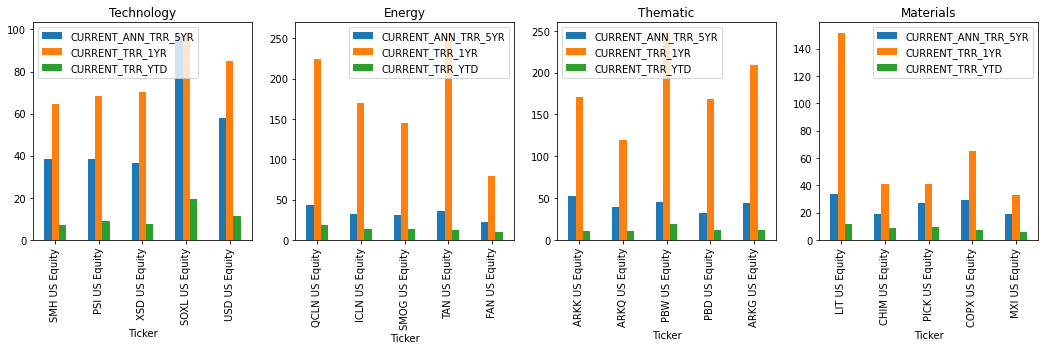

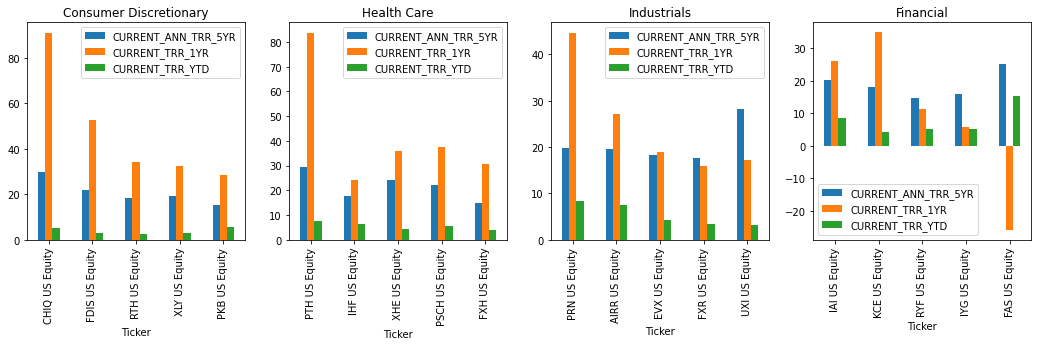

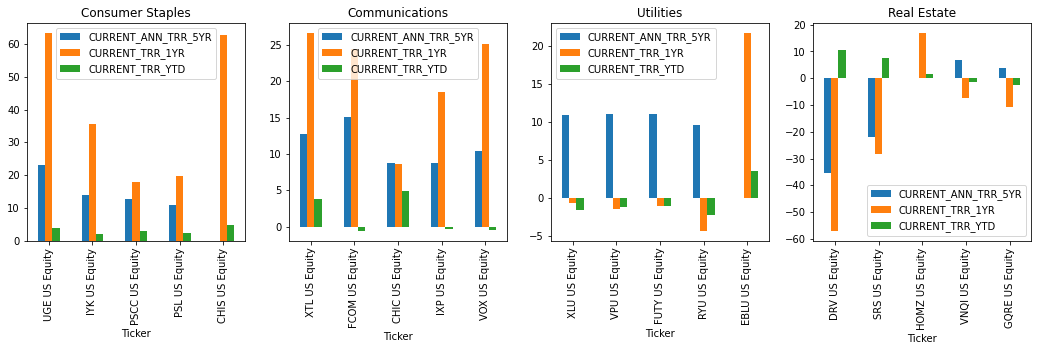

In [5]:
flds = ['EQY_SHARPE_RATIO_1YR','EQY_SHARPE_RATIO_5YR']
flds = ['CURRENT_ANN_TRR_5YR','CURRENT_TRR_1YR','CURRENT_TRR_YTD']

for i in range(0, len(industrylist),4):
    try: 
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))  
        df[df.industry == industrylist[i]][['style','industry','total_score'] + list(scoring_dic.keys())].head(5)[flds].plot(kind = 'bar', ax = axes[0], title =str(industrylist[i] ) )
        df[df.industry == industrylist[i+1]][['style','industry','total_score'] + list(scoring_dic.keys())].head(5)[flds].plot(kind = 'bar', ax = axes[1], title = str(industrylist[i+1]) )
        df[df.industry == industrylist[i+2]][['style','industry','total_score'] + list(scoring_dic.keys())].head(5)[flds].plot(kind = 'bar', ax = axes[2], title = str(industrylist[i+2]))
        df[df.industry == industrylist[i+3]][['style','industry','total_score'] + list(scoring_dic.keys())].head(5)[flds].plot(kind = 'bar', ax = axes[3], title = str(industrylist[i+3]) )
    except:
        None

### Recommendation by style, sort by total score

<AxesSubplot:title={'center':'Blend'}, xlabel='Ticker'>

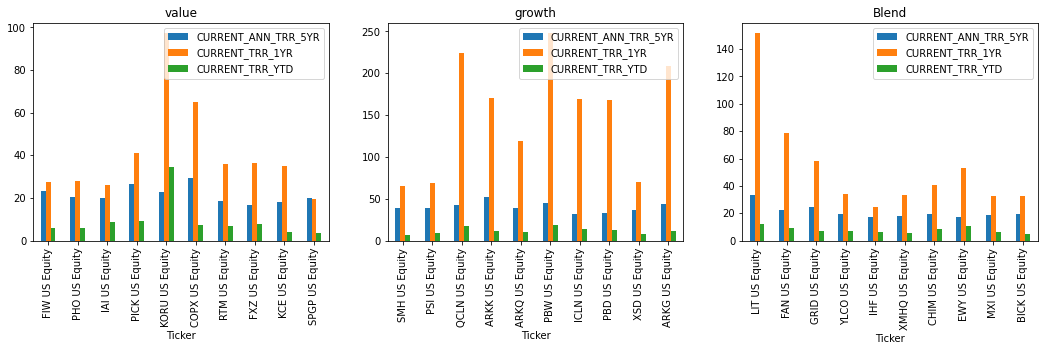

In [6]:
flds = ['EQY_SHARPE_RATIO_1YR','EQY_SHARPE_RATIO_5YR']
flds = ['CURRENT_ANN_TRR_5YR','CURRENT_TRR_1YR','CURRENT_TRR_YTD']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))  
df[df['style'] == 'Value'][['style','industry','total_score'] + list(scoring_dic.keys())].head(10)[flds].plot(kind = 'bar', ax = axes[0], title = 'value' )

df[df['style'] == 'Growth'][['style','industry','total_score'] + list(scoring_dic.keys())].head(10)[flds].plot(kind = 'bar', ax = axes[1], title = 'growth' )
df[df['style'] == 'Blend'][['style','industry','total_score'] + list(scoring_dic.keys())].head(10)[flds].plot(kind = 'bar', ax = axes[2], title = 'Blend' )



# Watchlist  Price

In [7]:
watchlist = pd.DataFrame()
for i in ['Value','Growth','Blend']:
    watchlist = watchlist.append(df[df['style'] == i][['style','industry','total_score'] + list(scoring_dic.keys())].head(10))
    

In [8]:
price = pd.read_csv('price.csv')
#price = price.iloc[:-5]
price.set_index('ticker',inplace = True)


startdate =( (pd.to_datetime(price.index[-1])) + timedelta(days = 1)).strftime('%Y%m%d')
con = pdblp.BCon(debug=False, port=8194,timeout=5000)
con.start()
newprice = con.bdh(list(watchlist.index),'PX_LAST',startdate,'20500101')
if len(newprice) > 0 :
    print('updating data since ' + startdate)
else: 
    print('No new price data')
    
newprice.columns =  newprice.columns.droplevel(level = 1)
price = price.append(newprice)
price.index.name ='ticker'

price.index  = pd.to_datetime(price.index )
price.to_csv('price.csv')

No new price data


In [9]:
price.iplot(title = 'Price from 2005~2050')

In [10]:
chg = price/price.shift(5)-1
chg.tail(1).sort_values(by  =chg.index[-1]  ,axis = 1, ascending = False ).iplot(kind ='bar',title = '1W price change')

In [11]:
chg = price/price.shift(26*3)-1
chg.tail(1).sort_values(by  =chg.index[-1]  ,axis = 1, ascending = False ).iplot(kind ='bar',title = '3m price change')

In [12]:
chg = price/price.shift(26*12)-1
chg.tail(1).sort_values(by  =chg.index[-1]  ,axis = 1, ascending = False ).iplot(kind ='bar',title = '1y price change')

In [13]:
def all_bar_plot(category,metric,top  ):
    rst = pd.DataFrame()
    for i in df[category].unique(): 
        subdf = df[df[category] == i]
        subdf = subdf.sort_values(by = metric, ascending = False).head(top)
        rst = rst.append(subdf)
    rst = rst.sort_values(by =metric, ascending = False)
    rst.reset_index(inplace = True)
    rst.set_index([category,'Ticker'],inplace = True)
    rst[[metric]].iplot(kind='bar',title = metric + ' by ' + category)

In [14]:
all_bar_plot('industry','CURRENT_TRR_YTD',3 )

In [15]:
all_bar_plot('industry','CURRENT_TRR_1YR',3 )

In [16]:
all_bar_plot('industry','CURRENT_TRR_3YR',3 )

In [17]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [28]:
!git add etf_screener.ipynb price.csv
!git config --global user.email "my2437@columbia.edu"
!git config --global user.name "windflower715"
!git commit -m"updated etf screener and price"
!git push


The file will have its original line endings in your working directory
